# Compare
### Models
1. BPR: Bayesian Personalized Ranking from Implicit Feedback
https://arxiv.org/abs/1205.2618
    1. Optimizes for AUC
2. (WARP) WSABIE: Scaling Up To Large Vocabulary Image Annotation http://www.thespermwhale.com/jaseweston/papers/wsabie-ijcai.pdf
    1. Optimizes for Precision@k
3. (k-OS WARP) Learning to Rank Recommendations with the k-Order Statistic Loss https://research.google.com/pubs/pub41534.html
    1. Optimizes for Precision@k
4. CLiMF: Learning to Maximize Reciprocal Rank with Collaborative Less-is-More Filtering
http://baltrunas.info/papers/Shi12-climf.pdf
    1. Optimizes for Reciprocal Rank

### Optimizers (other than vanilla SGD)
1. [NAdam](http://cs229.stanford.edu/proj2015/054_report.pdf)
2. [Nesterov](https://distill.pub/2017/momentum/)

### Data
- Movielens 100k https://grouplens.org/datasets/movielens/100k/
- README - http://files.grouplens.org/datasets/movielens/ml-100k-README.txt


## TODO
- speed up implementations (cython, c++, or numba/bottleneck)

In [1]:
import os
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, diags
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score, roc_curve, roc_auc_score
from sklearn.utils.extmath import safe_sparse_dot
import time
import math

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from warp import WARPNaive, KosWARP
from bpr import BPR
from climf import CLiMF
from optimizers import SGD, NAdam

In [4]:
dtype = np.float32

# load data

In [5]:
data_dir = "/Users/timwee/projects/datasets/movielens/ml-100k"

def load_data_from_f(fpath):
    # columns - user id | item id | rating | timestamp
    # user_id and item_id numbered consecutively from 1
    with open(fpath) as f:
        users, items, ratings = [], [], []
        max_user = -1
        max_item = -1
        for line in f:
            user_id, item_id, rating, ts = [int(tok) for tok in line.strip().split("\t")]
            # make it zero indexed
            user_id -= 1
            item_id -= 1
            max_user = max(max_user, user_id)
            max_item = max(max_item, item_id)
            users.append(user_id) 
            items.append(item_id)
            ratings.append(rating)
        return np.array(users), np.array(items), np.array(ratings), max_user, max_item


def train_and_test_data(data_dir, train_fname="ua.base", test_fname="ua.test", dtype=np.float32):
    trn_u, trn_i, trn_r, max_trn_u, max_trn_i = load_data_from_f(os.path.join(data_dir, train_fname))
    tst_u, tst_i, tst_r, max_tst_u, max_tst_i = load_data_from_f(os.path.join(data_dir, test_fname))
    num_rows = max(max_trn_u, max_tst_u) + 1
    num_cols = max(max_trn_i, max_tst_i) + 1
    return {"train" : coo_matrix((trn_r, (trn_u, trn_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr(), \
            "test" : coo_matrix((tst_r, (tst_u, tst_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr()}
    

In [6]:
movielens = train_and_test_data(data_dir, dtype=dtype)
train, test = movielens["train"], movielens["test"]
num_users, num_items = train.shape
train.shape, test.shape

((943, 1682), (943, 1682))

## helpers

In [7]:
def plot_metrics(toplot, xlabel, ylabel, title, ax):
    legend_lines = []
    legend_names = []
    for label, (xs, ys) in toplot.items():
        legend_lines.append(ax.plot(xs, ys, label=label)[0])
        legend_names.append(label)
    ax.legend(legend_lines, legend_names)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

In [10]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k, reciprocal_rank

In [9]:
num_epochs = 200
eval_interval = 10

# CLiMF

### Vanilla SGD

In [12]:
durations = []
tst_climf_auc = []
tst_climf_prec5 = []
tst_climf_rr = []

climf_sgd = SGD(lr=1e-4, decay=5e-4)

climf_model = CLiMF(climf_sgd, reg=0.001)
for epoch in range(num_epochs+1):
    start = time.time()
    climf_model.fit(train, cur_iter=epoch, debug=False, reset=False)
    duration = time.time() - start
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        durations.append(duration)    
        tst_auc = auc_score(climf_model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(climf_model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(climf_model, test, train_interactions=train).mean()
        tst_climf_auc.append(tst_auc)
        tst_climf_prec5.append(tst_prec5)
        tst_climf_rr.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings
iteration 0 took 9.3843, auc: 0.5021, p@5: 0.0066, rr: 0.0344
iteration 10 took 9.3570, auc: 0.5338, p@5: 0.0197, rr: 0.0730
iteration 20 took 9.4432, auc: 0.6517, p@5: 0.0611, rr: 0.1699
iteration 30 took 9.3843, auc: 0.7531, p@5: 0.1037, rr: 0.2712
iteration 40 took 9.5108, auc: 0.7991, p@5: 0.1205, rr: 0.3167
iteration 50 took 9.3163, auc: 0.8225, p@5: 0.1311, rr: 0.3368
iteration 60 took 9.3916, auc: 0.8331, p@5: 0.1340, rr: 0.3411
iteration 70 took 9.3695, auc: 0.8369, p@5: 0.1349, rr: 0.3409
iteration 80 took 9.3342, auc: 0.8360, p@5: 0.1313, rr: 0.3406
iteration 90 took 9.3436, auc: 0.8440, p@5: 0.1351, rr: 0.3383
iteration 100 took 9.3329, auc: 0.8504, p@5: 0.1396, rr: 0.3461
iteration 110 took 9.4090, auc: 0.8541, p@5: 0.1499, rr: 0.3661
iteration 120 took 9.3544, auc: 0.8489, p@5: 0.1561, rr: 0.3732
iteration 130 took 9.4016, auc: 0.8485, p@5: 0.1661, rr: 0.3809
iteration 140 took 9.4040, auc: 0.8530, p@5: 0.1769, rr: 0.3904
iteration 150 took 9.4375, 

### Nesterov Momentum

In [13]:
durations2 = []
tst_climf_auc2 = []
tst_climf_prec52 = []
tst_climf_rr2 = []

climf_sgd = SGD(lr=1e-4, decay=5e-4, nesterov=True, momentum=0.5)

climf_model2 = CLiMF(climf_sgd, reg=0.001)
for epoch in range(num_epochs+1):
    start = time.time()
    climf_model2.fit(train, cur_iter=epoch, debug=False, reset=False)
    duration = time.time() - start
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        durations2.append(duration)    
        tst_auc = auc_score(climf_model2, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(climf_model2, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(climf_model2, test, train_interactions=train).mean()
        tst_climf_auc2.append(tst_auc)
        tst_climf_prec52.append(tst_prec5)
        tst_climf_rr2.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings
iteration 0 took 9.8825, auc: 0.4963, p@5: 0.0059, rr: 0.0312
iteration 10 took 9.5412, auc: 0.6376, p@5: 0.0666, rr: 0.1726
iteration 20 took 9.4698, auc: 0.7914, p@5: 0.1181, rr: 0.3058
iteration 30 took 9.5085, auc: 0.8204, p@5: 0.1304, rr: 0.3277
iteration 40 took 9.5510, auc: 0.8315, p@5: 0.1266, rr: 0.3261
iteration 50 took 9.5339, auc: 0.8282, p@5: 0.1345, rr: 0.3299
iteration 60 took 9.5381, auc: 0.8165, p@5: 0.1459, rr: 0.3579
iteration 70 took 9.4502, auc: 0.8110, p@5: 0.1569, rr: 0.3715
iteration 80 took 9.4876, auc: 0.8184, p@5: 0.1635, rr: 0.3824
iteration 90 took 9.4858, auc: 0.8187, p@5: 0.1642, rr: 0.3854
iteration 100 took 9.5020, auc: 0.8251, p@5: 0.1754, rr: 0.3940
iteration 110 took 9.4825, auc: 0.8310, p@5: 0.1777, rr: 0.3891
iteration 120 took 9.5612, auc: 0.8338, p@5: 0.1811, rr: 0.3876
iteration 130 took 9.5443, auc: 0.8346, p@5: 0.1803, rr: 0.3894
iteration 140 took 9.5348, auc: 0.8326, p@5: 0.1786, rr: 0.3889
iteration 150 took 9.5128, 

## NAdam

In [14]:
durations_climf_nadam = []
tst_climf_auc_climf_nadam = []
tst_climf_prec5_climf_nadam = []
tst_climf_rr_climf_nadam = []

climf_nadam = NAdam(lr=1e-3)

climf_model_nadam = CLiMF(climf_nadam, reg=0.001)
for epoch in range(num_epochs+1):
    start = time.time()
    climf_model_nadam.fit(train, cur_iter=epoch, debug=False, reset=False)
    duration = time.time() - start
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        durations_climf_nadam.append(duration)    
        tst_auc = auc_score(climf_model_nadam, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(climf_model_nadam, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(climf_model_nadam, test, train_interactions=train).mean()
        tst_climf_auc_climf_nadam.append(tst_auc)
        tst_climf_prec5_climf_nadam.append(tst_prec5)
        tst_climf_rr_climf_nadam.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings
iteration 0 took 9.8308, auc: 0.4982, p@5: 0.0055, rr: 0.0331
iteration 10 took 9.5539, auc: 0.6227, p@5: 0.0318, rr: 0.1138
iteration 20 took 9.5638, auc: 0.8299, p@5: 0.1264, rr: 0.3287
iteration 30 took 9.5676, auc: 0.8456, p@5: 0.1247, rr: 0.3371
iteration 40 took 9.5479, auc: 0.8500, p@5: 0.1253, rr: 0.3370
iteration 50 took 9.6086, auc: 0.8551, p@5: 0.1296, rr: 0.3422
iteration 60 took 9.5796, auc: 0.8626, p@5: 0.1525, rr: 0.3567
iteration 70 took 9.5963, auc: 0.8727, p@5: 0.1741, rr: 0.3921
iteration 80 took 9.6063, auc: 0.8829, p@5: 0.1953, rr: 0.4071
iteration 90 took 9.5620, auc: 0.8912, p@5: 0.2028, rr: 0.4337
iteration 100 took 9.4856, auc: 0.8965, p@5: 0.2076, rr: 0.4547
iteration 110 took 9.5067, auc: 0.9004, p@5: 0.2148, rr: 0.4635
iteration 120 took 9.5182, auc: 0.9030, p@5: 0.2257, rr: 0.4770
iteration 130 took 9.5702, auc: 0.9032, p@5: 0.2274, rr: 0.4766
iteration 140 took 9.5558, auc: 0.9026, p@5: 0.2308, rr: 0.4755
iteration 150 took 9.5448, 

### compare optimizers on CLiMF

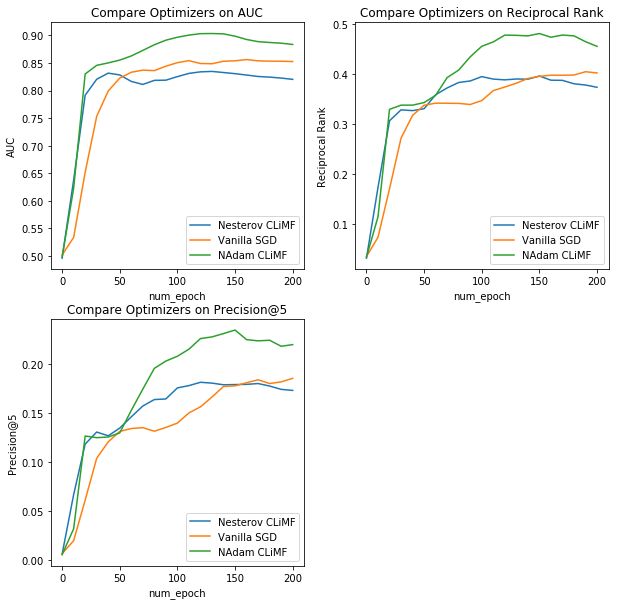

In [18]:
plt.figure(figsize=(10,10))

xs = np.arange(len(tst_climf_auc_climf_nadam)) * eval_interval
ax1 = plt.subplot(221)
# plot auc
plot_metrics({"NAdam CLiMF" : (xs, tst_climf_auc_climf_nadam), \
              "Nesterov CLiMF" : (xs, tst_climf_auc2), \
              "Vanilla SGD" : (xs, tst_climf_auc)}, \
              "num_epoch", "AUC", "Compare Optimizers on AUC", ax1)

ax2 = plt.subplot(222)
plot_metrics({"NAdam CLiMF" : (xs, tst_climf_rr_climf_nadam), \
              "Nesterov CLiMF" : (xs, tst_climf_rr2), \
              "Vanilla SGD" : (xs, tst_climf_rr)}, \
              "num_epoch", "Reciprocal Rank", "Compare Optimizers on Reciprocal Rank", ax2)

ax3 = plt.subplot(223)
plot_metrics({"NAdam CLiMF" : (xs, tst_climf_prec5_climf_nadam), \
              "Nesterov CLiMF" : (xs, tst_climf_prec52), \
              "Vanilla SGD" : (xs, tst_climf_prec5)}, \
              "num_epoch", "Precision@5", "Compare Optimizers on Precision@5", ax3)

plt.show()

# KOS Warp

In [15]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

durations = []
tst_koswarp_auc = []
tst_koswarp_prec5 = []
tst_koswarp_rr = []

kos_nadam = NAdam(lr=1e-3, decay=1e-5)

kos_model = KosWARP(optim=kos_nadam, item_reg=0.001, user_reg=0.001)
for epoch in range(num_epochs+1):
    start = time.time()
    kos_model.fit(train, reset=False)
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        duration = time.time() - start
        durations.append(duration)    
        tst_auc = auc_score(kos_model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(kos_model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(kos_model, test, train_interactions=train).mean()
        tst_koswarp_auc.append(tst_auc)
        tst_koswarp_prec5.append(tst_prec5)
        tst_koswarp_rr.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings and biases
iteration 0 took 23.4055, auc: 0.8280, p@5: 0.0477, rr: 0.1603
iteration 10 took 23.5942, auc: 0.8381, p@5: 0.0416, rr: 0.1373
iteration 20 took 23.4887, auc: 0.8638, p@5: 0.0513, rr: 0.1632
iteration 30 took 23.5725, auc: 0.8806, p@5: 0.0694, rr: 0.1868
iteration 40 took 23.5139, auc: 0.8882, p@5: 0.0827, rr: 0.2087
iteration 50 took 23.5659, auc: 0.8923, p@5: 0.0923, rr: 0.2307
iteration 60 took 23.4554, auc: 0.8946, p@5: 0.1092, rr: 0.2534
iteration 70 took 23.3872, auc: 0.8961, p@5: 0.1137, rr: 0.2618
iteration 80 took 23.3606, auc: 0.8971, p@5: 0.1169, rr: 0.2727
iteration 90 took 23.4634, auc: 0.8979, p@5: 0.1169, rr: 0.2719
iteration 100 took 23.5226, auc: 0.8984, p@5: 0.1200, rr: 0.2710
iteration 110 took 23.4470, auc: 0.8986, p@5: 0.1188, rr: 0.2752
iteration 120 took 23.4472, auc: 0.8989, p@5: 0.1215, rr: 0.2830
iteration 130 took 23.5523, auc: 0.8991, p@5: 0.1190, rr: 0.2839
iteration 140 took 23.4621, auc: 0.8993, p@5: 0.1251, rr: 0.2878
i

## WARP

In [16]:
durations = []
tst_warp_auc = []
tst_warp_prec5 = []
tst_warp_rr = []

warp_nadam = NAdam(lr=1e-3, decay=1e-5)
model = WARPNaive(optim=warp_nadam, item_reg=0.001, user_reg=0.001)

for epoch in range(num_epochs+1):
    start = time.time()
    model.fit(train, reset=False)
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        duration = time.time() - start
        durations.append(duration)    
        tst_auc = auc_score(model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(model, test, train_interactions=train).mean()
        tst_warp_auc.append(tst_auc)
        tst_warp_prec5.append(tst_prec5)
        tst_warp_rr.append(tst_rr)
        print("warp iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings and biases
warp iteration 0 took 19.6331, auc: 0.7684, p@5: 0.0416, rr: 0.1464
warp iteration 10 took 19.7605, auc: 0.7846, p@5: 0.0437, rr: 0.1568
warp iteration 20 took 19.8610, auc: 0.7879, p@5: 0.0445, rr: 0.1605
warp iteration 30 took 20.2170, auc: 0.7891, p@5: 0.0443, rr: 0.1609
warp iteration 40 took 22.0151, auc: 0.7906, p@5: 0.0458, rr: 0.1637
warp iteration 50 took 23.7385, auc: 0.7914, p@5: 0.0462, rr: 0.1671
warp iteration 60 took 25.1928, auc: 0.7916, p@5: 0.0471, rr: 0.1699
warp iteration 70 took 25.9921, auc: 0.7920, p@5: 0.0484, rr: 0.1722
warp iteration 80 took 26.6619, auc: 0.7921, p@5: 0.0513, rr: 0.1769
warp iteration 90 took 27.1255, auc: 0.7925, p@5: 0.0520, rr: 0.1818
warp iteration 100 took 27.3861, auc: 0.7926, p@5: 0.0541, rr: 0.1861
warp iteration 110 took 27.6644, auc: 0.7927, p@5: 0.0568, rr: 0.1919
warp iteration 120 took 27.9865, auc: 0.7928, p@5: 0.0594, rr: 0.1949
warp iteration 130 took 27.8363, auc: 0.7929, p@5: 0.0615, rr: 0.1

## BPR Class

In [17]:
durations = []
tst_bpr_auc = []
tst_bpr_prec5 = []
tst_bpr_rr = []

bpr_nadam = NAdam(lr=1e-3, decay=1e-5)
bpr_model = BPR(optim=bpr_nadam, item_reg=0.001, user_reg=0.001)
for epoch in range(num_epochs + 1):
    start = time.time()
    bpr_model.fit(train, reset=False)
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        duration = time.time() - start
        durations.append(duration)    
        tst_auc = auc_score(bpr_model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(bpr_model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(bpr_model, test, train_interactions=train).mean()
        tst_bpr_auc.append(tst_auc)
        tst_bpr_prec5.append(tst_prec5)
        tst_bpr_rr.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings and biases
iteration 0 took 20.4267, auc: 0.7659, p@5: 0.0378, rr: 0.1170
iteration 10 took 20.4110, auc: 0.7846, p@5: 0.0437, rr: 0.1553
iteration 20 took 20.3039, auc: 0.7859, p@5: 0.0450, rr: 0.1571
iteration 30 took 20.1851, auc: 0.7869, p@5: 0.0456, rr: 0.1568
iteration 40 took 20.3015, auc: 0.7878, p@5: 0.0452, rr: 0.1636
iteration 50 took 20.3273, auc: 0.7885, p@5: 0.0450, rr: 0.1648
iteration 60 took 20.5828, auc: 0.7890, p@5: 0.0462, rr: 0.1605
iteration 70 took 20.4526, auc: 0.7891, p@5: 0.0473, rr: 0.1679
iteration 80 took 20.3525, auc: 0.7894, p@5: 0.0486, rr: 0.1702
iteration 90 took 20.4834, auc: 0.7896, p@5: 0.0486, rr: 0.1717
iteration 100 took 20.3041, auc: 0.7897, p@5: 0.0496, rr: 0.1737
iteration 110 took 20.4948, auc: 0.7897, p@5: 0.0503, rr: 0.1747
iteration 120 took 20.4203, auc: 0.7898, p@5: 0.0509, rr: 0.1761
iteration 130 took 20.6013, auc: 0.7898, p@5: 0.0517, rr: 0.1769
iteration 140 took 20.4694, auc: 0.7899, p@5: 0.0513, rr: 0.1782
i

# compare algos

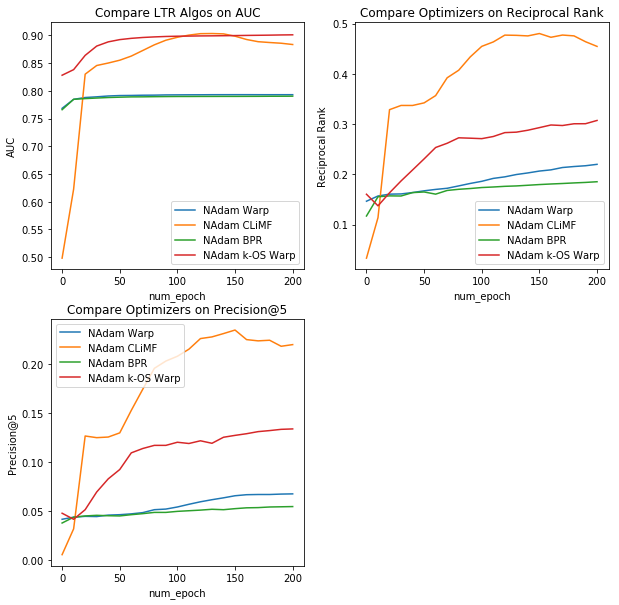

In [19]:
plt.figure(figsize=(10,10))

xs = np.arange(len(tst_climf_auc_climf_nadam)) * eval_interval
ax1 = plt.subplot(221)
# plot auc
plot_metrics({"NAdam CLiMF" : (xs, tst_climf_auc_climf_nadam), \
              "NAdam BPR" : (xs, tst_bpr_auc), \
              "NAdam Warp" : (xs, tst_warp_auc), \
              "NAdam k-OS Warp" : (xs, tst_koswarp_auc)}, \
              "num_epoch", "AUC", "Compare LTR Algos on AUC", ax1)


ax2 = plt.subplot(222)
plot_metrics({"NAdam CLiMF" : (xs, tst_climf_rr_climf_nadam), \
              "NAdam BPR" : (xs, tst_bpr_rr), \
              "NAdam Warp" : (xs, tst_warp_rr), \
              "NAdam k-OS Warp" : (xs, tst_koswarp_rr)}, \
              "num_epoch", "Reciprocal Rank", "Compare Optimizers on Reciprocal Rank", ax2)

ax3 = plt.subplot(223)
plot_metrics({"NAdam CLiMF" : (xs, tst_climf_prec5_climf_nadam), \
              "NAdam BPR" : (xs, tst_bpr_prec5), \
              "NAdam Warp" : (xs, tst_warp_prec5), \
              "NAdam k-OS Warp" : (xs, tst_koswarp_prec5)}, \
              "num_epoch", "Precision@5", "Compare Optimizers on Precision@5", ax3)


plt.show()